In [37]:
import Pkg

packages = [
    "BoundaryValueDiffEq",
    "ModelingToolkit",
    "MethodOfLines",
    "DifferentialEquations",
    "NonlinearSolve",
    "DomainSets",
    "FFTW",
    "Plots",
    "BifurcationKit",
    "LinearAlgebra",
    "SparseArrays",
    "Setfield",
    "Accessors",
    "KrylovKit",
]

Pkg.add(packages)

   Resolving package versions...
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Manifest.toml`


In [38]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using NonlinearSolve
using DomainSets
using FFTW
using Plots
using BifurcationKit
using Setfield 
using Accessors
using KrylovKit

In [39]:
# 1. Define the PDE 
function wave_equation_1d!(du, u, p, t)
    N = p.N
    dx = p.dx
    c2 = p.g * p.H
    eta = @view u[1:N]
    v   = @view u[N+1:2N]
    
    d_eta = @view du[1:N]
    d_v   = @view du[N+1:2N]
    
    # Loop over grid points
    for i in 1:N
        # 1. Kinematics
        d_eta[i] = v[i]
        
        # 2. Dynamics: Wave Equation
        eta_left  = (i == 1) ? 0.0 : eta[i-1]
        eta_right = (i == N) ? 0.0 : eta[i+1]
        
        laplacian = (eta_right - 2*eta[i] + eta_left) / (dx^2)
        
        # Non-linear Damping
        damping = p.gamma * v[i] + p.gamma3 * v[i]^3
        
        # Driving Force
        forcing = p.F0 * sin(p.omega * t)
        
        # Acceleration equation
        d_v[i] = c2 * laplacian + forcing - damping
    end
end 

wave_equation_1d! (generic function with 1 method)

In [40]:
# 2. Parameters 
L = 10.0
N = 10 
dx = L / (N + 1)


par_base = (
    N = N,
    dx = dx,
    g = 9.81,    
    H = 1.5,     
    gamma = 0.05,  
    gamma3 = 0.0,  
    F0 = 5.0,    
    omega = 0.1  
)

(N = 10, dx = 0.9090909090909091, g = 9.81, H = 1.5, gamma = 0.05, gamma3 = 0.0, F0 = 5.0, omega = 0.1)

In [41]:
# 3. Poincaré Map 
function poincare_map_wave(u, p)
    omega = (p isa Real) ? p : p.omega
    T = 2π / abs(omega)
    
    # Integrate the high-dimensional system
    prob = ODEProblem(wave_equation_1d!, u, (0.0, T), p))
    sol = solve(prob, Rodas4(), reltol=1e-6, abstol=1e-6, save_everystep=false)
    return sol[end] - u
end 

poincare_map_wave (generic function with 1 method)

In [42]:
# 4. Helper Function to Run Continuation 
function run_wave_continuation(gamma3_val, label_str)
    println("Running simulation for $label_str (gamma3 = $gamma3_val)...")
    
    # Update parameters
    par_current = merge(par_base, (gamma3 = gamma3_val,))
    
    # Initial guess
    u0 = zeros(2*N)

    # Define Problem
    prob = BifurcationProblem(poincare_map_wave, u0, par_current, (@optic _.omega);
        record_from_solution = (x, p; k...) -> begin
            curr_omega = (p isa Real) ? p : p.omega
            
            # Reconstruct full parameters using par_current
            p_full = merge(par_current, (omega = Float64(curr_omega),))
            
            T = 2π / p_full.omega
            prob_rec = ODEProblem(wave_equation_1d!, x, (0.0, T), p_full)
            sol_rec = solve(prob_rec, Tsit5(), reltol=1e-6, abstol=1e-6)
            
            # Return center amplitude
            mid_idx = Int(div(p_full.N, 2))
            return maximum(abs.(sol_rec[mid_idx, :]))
        end
    )

    # Options
    opts = ContinuationPar(
        p_min = 0.01, 
        p_max = 16.0,      
        ds = 0.02,
        max_steps = 4000, 
        detect_bifurcation = 0
    )

    # Run
    return continuation(prob, PALC(), opts)
end

run_wave_continuation (generic function with 1 method)

In [43]:
# 5. Run Cases 
# Case A: Linear
@time branch_linear = run_wave_continuation(0.001, "Linear")

# Case B: Non-Linear Low
@time branch_nonlinear1 = run_wave_continuation(0.01, "Non-Linear")

# Case C: Non-Linear High
@time branch_nonlinear2 = run_wave_continuation(0.05, "Non-Linear")

Running simulation for Linear (gamma3 = 0.001)...
566.767302 seconds (62.30 M allocations: 71.999 GiB, 3.35% gc time, 1.46% compilation time: 3% of which was recompilation)
Running simulation for Non-Linear (gamma3 = 0.01)...
395.924371 seconds (35.44 M allocations: 48.455 GiB, 3.21% gc time)
Running simulation for Non-Linear (gamma3 = 0.05)...
265.464043 seconds (24.02 M allocations: 33.049 GiB, 3.68% gc time)


 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 215
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter omega starts at 0.1, ends at 16.0
 ├─ Algo: PALC [Secant]
 └─ Special points:

- #  1, endpoint at omega ≈ +16.00000000,                                                                     step = 214


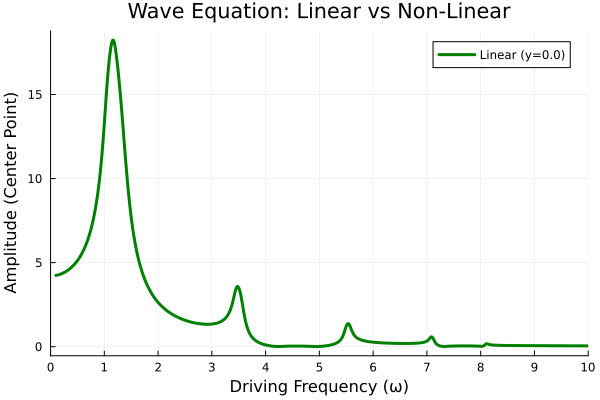

In [44]:
# 6. Plotting 
p = plot(branch_linear, 
    title = "Wave Equation: Linear vs Non-Linear",
    xlabel = "Driving Frequency (ω)",
    ylabel = "Amplitude (Center Point)",
    label = "Linear (y=0.0)",
    lw = 3, 
    color = :green,
    xlims = (0, 10),
    xticks = 0:1:10,
    legend = :topright
)

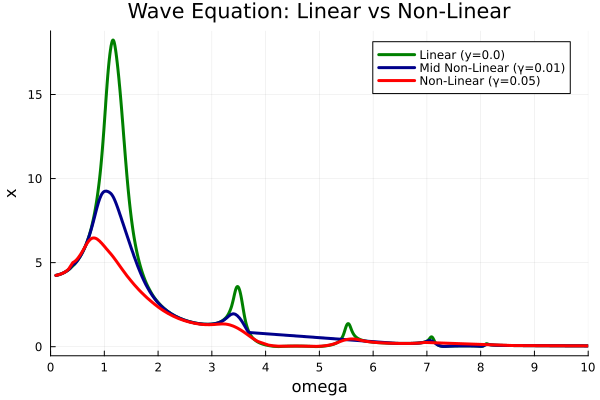

In [45]:
# Plot Non-Linear on top
plot!(p, branch_nonlinear1, 
    label = "Mid Non-Linear (γ=0.01)",
    lw = 3, 
    color = :darkblue,
    linestyle = :solid
)

plot!(p, branch_nonlinear2, 
    label = "Non-Linear (γ=0.05)",
    lw = 3, 
    color = :red,
    linestyle = :solid
)

display(p)